## Basic Setup

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd

import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from evaluation.plots import plot_history

In [2]:
# Hyperparameter to tune
config = {
    "comment" : "actual long run",
    "epochs" : 100,
    "loss" : "mae",
    "optimizer" : "adam",
    "dropout" : 0.3,
    "batch_size" : 32,
    "bottle_neck_dim" : 512,
    "threshold_percentage" : 95,
    "data_class" : "screw",
    "model_type" : "autoencoder"
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [3]:
import os

def get_root_dir() -> str:
    """
    Get the root directory of the repository.

    This function traverses up the directory tree until it finds the root directory
    of the repository, identified by the presence of a '.git' directory.

    Returns:
    str: The root directory of the repository.
    """
    current_dir = os.getcwd()
    
    # Traverse up the directory tree until you find the root directory of the repo
    while not os.path.exists(os.path.join(current_dir, '.git')):
        current_dir = os.path.dirname(current_dir)

    return current_dir

root_dir = get_root_dir()

In [4]:
wandb.init(project="itu-aml-project", config=config)
config = wandb.config # this turns our hyperparameter config into a proper object with attributes

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hendrik-spl (itu-aml-project). Use `wandb login --relogin` to force relogin


In [5]:
model_dir = os.path.join(root_dir, 'models', config.model_type)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{config.comment}_checkpoint.model.keras')
history_path = os.path.join(model_dir, 'logs', 'history', f'{config.comment}_history.csv')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{config.comment}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

In [6]:
# set the random seeds to make sure that the results are reproducible
def set_seed(seed: int) -> None:
    """
    Set the random seed for numpy, random, TensorFlow, and Keras to ensure reproducibility.

    Parameters:
    seed (int): The seed value to set for random number generation.
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)
                                
set_seed(1234)

In [7]:
import tensorflow as tf
import platform

def setup_gpu() -> None:
    """
    Configures TensorFlow to use GPU if available, otherwise defaults to CPU.

    This function checks for available GPUs and sets memory growth to avoid
    TensorFlow from allocating all GPU memory at once. It also handles
    platform-specific configurations for macOS and other platforms.

    Raises:
        RuntimeError: If there is an error in setting memory growth.
    """
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            if platform.system() == 'Darwin':  # macOS
                tf.config.experimental.set_memory_growth(gpus[0], True)
                print("Configured TensorFlow to use Metal on macOS.")
            else:  # Assume CUDA for other platforms
                tf.config.experimental.set_memory_growth(gpus[0], True)
                print("Configured TensorFlow to use CUDA.")
        except RuntimeError as e:
            print(e)
    else:
        print("No GPU found, using CPU.")

setup_gpu()

No GPU found, using CPU.


In [8]:
def get_data(category: str, batch_size: int):
    """
    Generates data generators for training, validation, and testing datasets.

    Args:
        category (str): The category of the dataset to be used.
        batch_size (int): The size of the batches of data.

    Returns:
        Tuple[DirectoryIterator, DirectoryIterator, DirectoryIterator]: 
        A tuple containing the training data generator, validation data generator, and test data generator.
    """
    data_dir = f'../../data/{category}'
    train_dir = f'{data_dir}/train'
    test_dir = f'{data_dir}/test'

    datagen_train = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.2
        )

    datagen_test = ImageDataGenerator(
        rescale=1./255
        )

    train_generator = datagen_train.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='input',
        color_mode='rgb',
        subset='training'
    )

    validation_generator = datagen_train.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='input',
        color_mode='rgb',
        subset='validation',
        shuffle=False
    )

    test_generator = datagen_test.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = get_data(category=config.data_class, batch_size=config.batch_size)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 160 images belonging to 6 classes.


In [ ]:
def build_autoencoder(input_shape, optimizer, loss, dropout, bottleneck_dim):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (128, 128, 32)
    x = Dropout(dropout)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (64, 64, 64)+
    x = Dropout(dropout)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (32, 32, 128)
    x = Dropout(dropout)(x)

    # Bottleneck
    x = Flatten()(x)                        # Flattened Shape: (32 * 32 * 128,)
    encoded = Dense(bottleneck_dim)(x)      # Latent space size reduced to 512
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU(name='bottleneck')(encoded)

    # Decoder
    x = Dense(32 * 32 * 128)(encoded)
    x = Reshape((32, 32, 128))(x)

    x = UpSampling2D((2, 2))(x)  # (64, 64, 128)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (128, 128, 64)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (256, 256, 32)
    x = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, x)
    autoencoder.compile(
        optimizer=optimizer, 
        loss=loss,
        metrics=['accuracy']
        )
    
    return autoencoder

autoencoder = build_autoencoder(input_shape=INPUT_SHAPE, optimizer=config.optimizer, loss=config.loss, dropout=config.dropout, bottleneck_dim=config.bottle_neck_dim)

In [10]:
early_stop = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=10, 
    start_from_epoch=10
    )

checkpoint = ModelCheckpoint(
    cpkt_path, 
    monitor="val_loss", 
    mode="min", 
    save_best_only=True, 
    verbose=1
    )

In [ ]:
history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        early_stop,
        checkpoint,
        WandbMetricsLogger(),
        # WandbModelCheckpoint("models"), # Saves model checkpoint to W&B
    ],
)

wandb.finish()

/Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.3107 - loss: 0.2156 
Epoch 1: val_loss improved from inf to 0.17167, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/actual long run_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 157s 19s/step - accuracy: 0.3063 - loss: 0.2091 - val_accuracy: 0.1473 - val_loss: 0.1717
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.3745 - loss: 0.0621 
Epoch 2: val_loss did not improve from 0.17167
8/8 ━━━━━━━━━━━━━━━━━━━━ 149s 19s/step - accuracy: 0.3777 - loss: 0.0616 - val_accuracy: 0.2436 - val_loss: 0.2004
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.3503 - loss: 0.0463 
Epoch 3: val_loss improved from 0.17167 to 0.11389, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/actual long run_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 136s 17s/step - accuracy

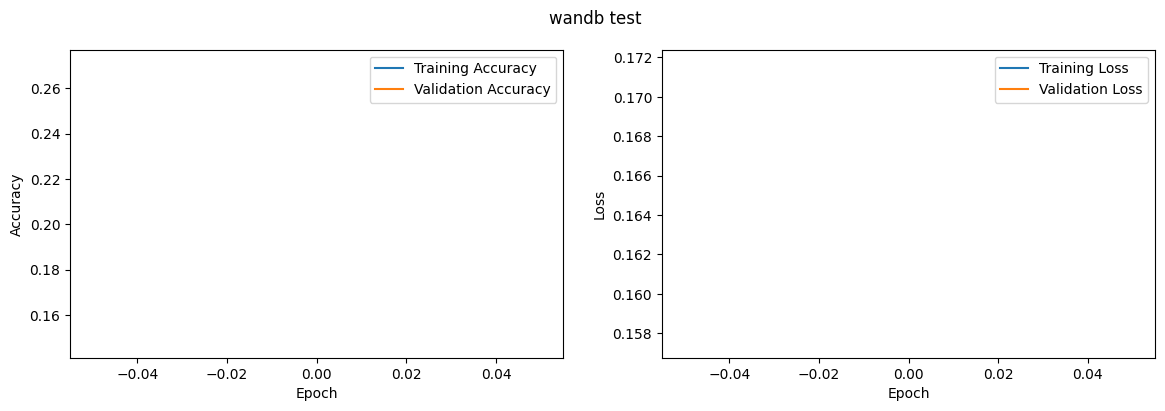

Best train_accuracy: 0.2708
Best train_loss: 0.1575
Best val_accuracy: 0.1473
Best val_loss: 0.1717
Last improvement at epoch: 1


In [ ]:
# plot the training history
plot_history(comment=config.comment, history=history)

In [ ]:
# save the history
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.to_csv(history_path, index=False)

In [ ]:
# load the best model
autoencoder.load_weights(cpkt_path)

In [ ]:
# save the model
autoencoder.save(weights_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


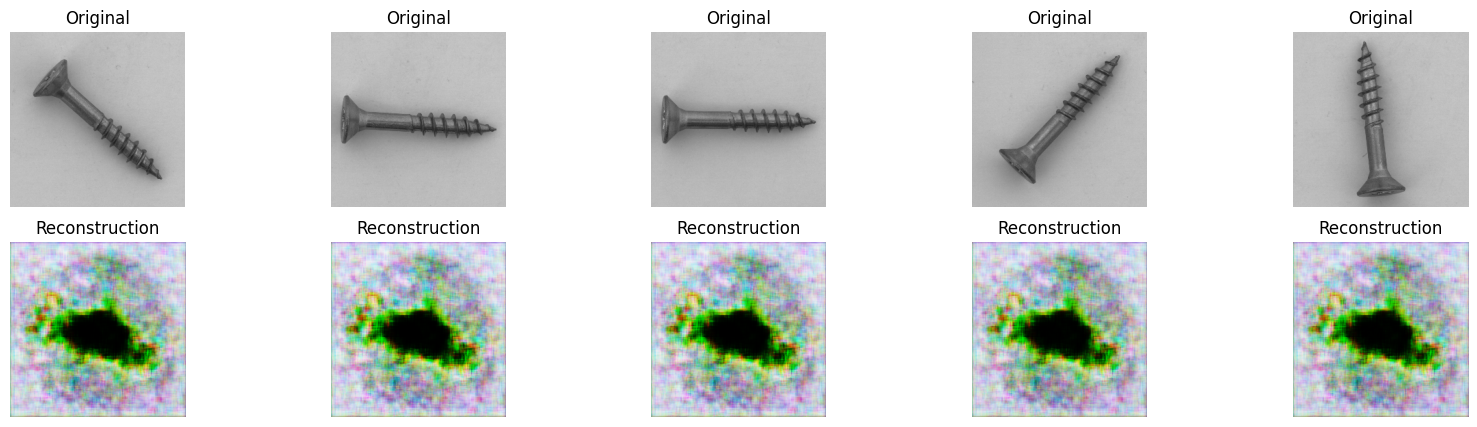

In [ ]:
def plot_reconstructions(autoencoder: Model, test_generator: ImageDataGenerator, n_images: int) -> None:
    """
    Plot original and reconstructed images from the autoencoder.

    Parameters:
    autoencoder (Model): The autoencoder model.
    test_generator (ImageDataGenerator): The test data generator.
    n_images (int): The number of images to plot.
    """
    test_images, _ = next(test_generator)
    reconstructions = autoencoder.predict(test_images)

    fig, axes = plt.subplots(2, n_images, figsize=(20, 5))

    for i in range(n_images):
        axes[0, i].imshow(test_images[i])
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(reconstructions[i])
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstruction')

    plt.show()

plot_reconstructions(autoencoder, test_generator, n_images=5)

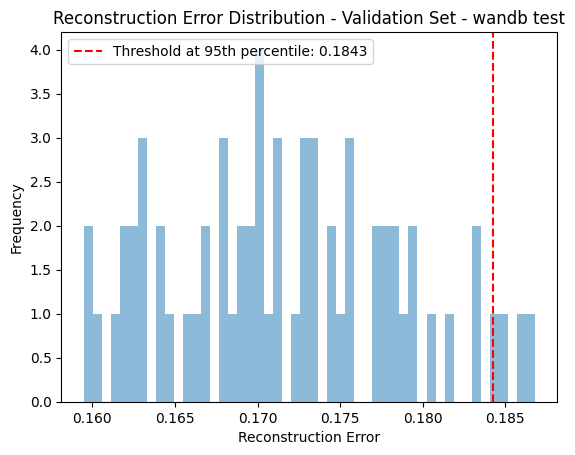

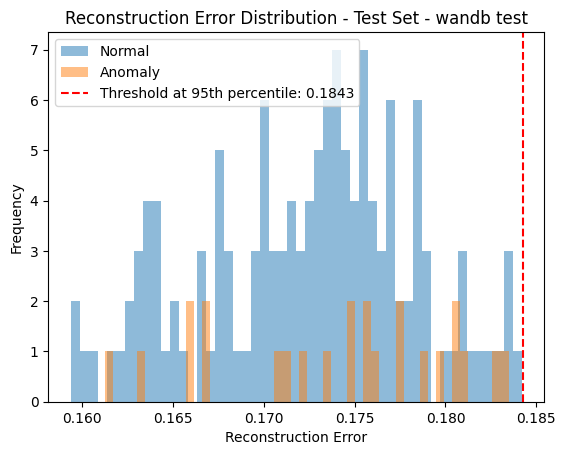

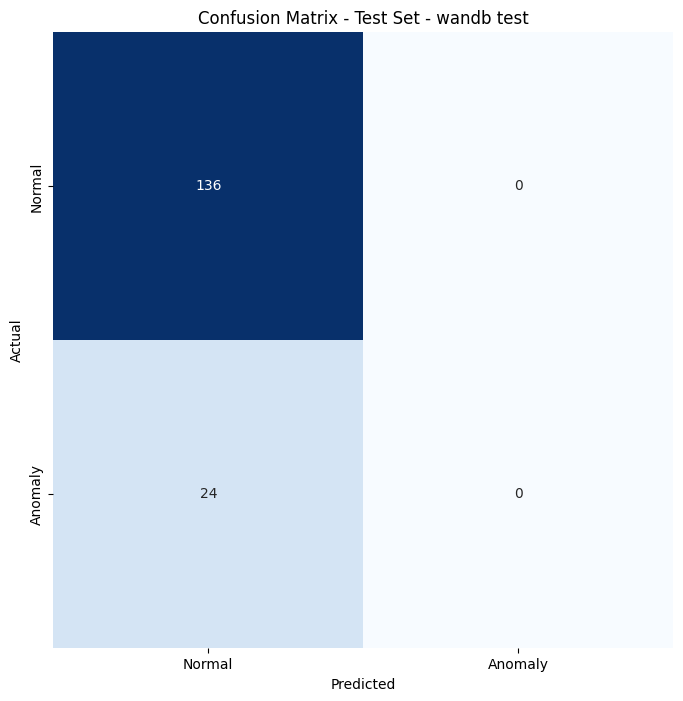

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple

def calculate_error(images: np.ndarray, reconstructions: np.ndarray, loss_function: str) -> List[float]:
    """
    Calculate error between original images and their reconstructions.

    Parameters:
    images (np.ndarray): The original images.
    reconstructions (np.ndarray): The reconstructed images.
    loss_function (str): The loss function to use ('mae' or 'mse').

    Returns:
    List[float]: A list of errors.
    """
    if loss_function == 'mae':
        return np.mean(np.abs(reconstructions - images), axis=(1, 2, 3))
    elif loss_function == 'mse':
        return np.mean(np.square(reconstructions - images), axis=(1, 2, 3))
    else:
        raise ValueError(f"Unknown loss function: {loss_function}. Please define a function to calculate the error.")

def get_errors_and_labels(autoencoder: Model, generator: ImageDataGenerator, loss_function: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate errors and true labels.

    Parameters:
    autoencoder (Model): The autoencoder model.
    generator (ImageDataGenerator): The test data generator.
    loss_function (str): The loss function to use ('mae' or 'mse').

    Returns:
    Tuple[np.ndarray, np.ndarray]: Arrays of test errors and true labels.
    """
    errors = []
    labels = []
    for i in range(len(generator)):
        batch_images, batch_labels = next(generator)
        reconstructions = autoencoder.predict(batch_images, verbose=0)
        batch_errors = calculate_error(batch_images, reconstructions, loss_function)
        errors.extend(batch_errors)
        labels.extend(batch_labels[:, 1])
    return np.array(errors), np.array(labels)

def get_threshold(errors: np.ndarray, percentage: int) -> float:
    """
    Calculate the threshold based on the errors.

    Parameters:
    errors (List[float]): The errors.
    percentage (int): The percentile to use for the threshold.

    Returns:
    float: The calculated threshold.
    """
    return np.percentile(errors, percentage)

def plot_single_histogram_with_threshold(errors: List[float], threshold: float, title: str, xlabel: str, ylabel: str, threshold_label: str) -> None:
    """
    Plot a single histogram with a threshold line.

    Parameters:
    errors (List[float]): The errors to plot.
    threshold (float): The threshold value.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    threshold_label (str): The label for the threshold line.
    """
    plt.hist(errors, bins=50, alpha=0.5)
    plt.axvline(threshold, color='r', linestyle='--', label=threshold_label)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_double_histogram_with_threshold(normal_errors: List[float], anomaly_errors: List[float], threshold: float, title: str, xlabel: str, ylabel: str, threshold_label: str) -> None:
    """
    Plot two histograms (normal and anomaly errors) with a threshold line.

    Parameters:
    normal_errors (List[float]): The normal errors to plot.
    anomaly_errors (List[float]): The anomaly errors to plot.
    threshold (float): The threshold value.
    title (str): The title of the plot.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    threshold_label (str): The label for the threshold line.
    """
    plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal')
    plt.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomaly')
    plt.axvline(threshold, color='r', linestyle='--', label=threshold_label)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_confusion_matrix(confusion_matrix: np.ndarray, labels: List[str], title: str) -> None:
    """
    Plot a confusion matrix.

    Parameters:
    confusion_matrix (np.ndarray): The confusion matrix to plot.
    labels (List[str]): The labels for the confusion matrix.
    title (str): The title of the plot.
    """
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def evaluate_autoencoder(autoencoder: Model, validation_generator: ImageDataGenerator, test_generator: ImageDataGenerator) -> None:
    """
    Evaluate the autoencoder model.

    Parameters:
    autoencoder (Model): The autoencoder model.
    validation_generator (ImageDataGenerator): The validation data generator.
    test_generator (ImageDataGenerator): The test data generator.
    """
    ground_truth_labels = [
        "Normal", # 0
        "Anomaly" # 1
        ]

    # Step 1: Calculate reconstruction error on the validation set
    validation_errors, _ = get_errors_and_labels(
        autoencoder=autoencoder, 
        generator=validation_generator, 
        loss_function=config.loss
    )

    # Step 2: Calculate threshold based on the reconstruction error
    threshold = get_threshold(
        errors=validation_errors, 
        percentage=config.threshold_percentage
    )

    # Step 3: Plot error distribution with threshold
    plot_single_histogram_with_threshold(
        errors=validation_errors,
        threshold=threshold,
        title=f"Reconstruction Error Distribution - Validation Set - {config.comment}",
        xlabel="Reconstruction Error",
        ylabel="Frequency",
        threshold_label=f"Threshold at {config.threshold_percentage}th percentile: {threshold:.4f}",
    )

    # Step 4: Calculate test errors and labels
    test_errors, true_labels = get_errors_and_labels(
        autoencoder=autoencoder, 
        generator=test_generator, 
        loss_function=config.loss
    )

    # Step 5: Adjust true labels to match the class indices
    true_labels = np.where(true_labels == test_generator.class_indices["good"], 0, 1)

    # Step 6: Predict labels based on the threshold
    predicted_labels = np.where(test_errors > threshold, 1, 0)

    # Step 7: Calculate metrics
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Step 8: Split errors based on the true labels
    normal_errors = test_errors[true_labels == 0]
    anomalous_errors = test_errors[true_labels == 1]

    # Step 9: Plot error distribution for normal and anomalous samples
    plot_double_histogram_with_threshold(
        normal_errors,
        anomalous_errors,
        threshold,
        f"Reconstruction Error Distribution - Test Set - {config.comment}",
        "Reconstruction Error",
        "Frequency",
        f"Threshold at {config.threshold_percentage}th percentile: {threshold:.4f}",
    )

    # Step 10: Plot confusion matrix
    plot_confusion_matrix(conf_matrix, ground_truth_labels, f"Confusion Matrix - Test Set - {config.comment}")

evaluate_autoencoder(
    autoencoder=autoencoder,
    validation_generator=validation_generator,
    test_generator=test_generator
    )

/var/folders/4v/mg6gp3rx0yj803ddxqcd01bc0000gn/T/ipykernel_64916/1743447053.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_classes)


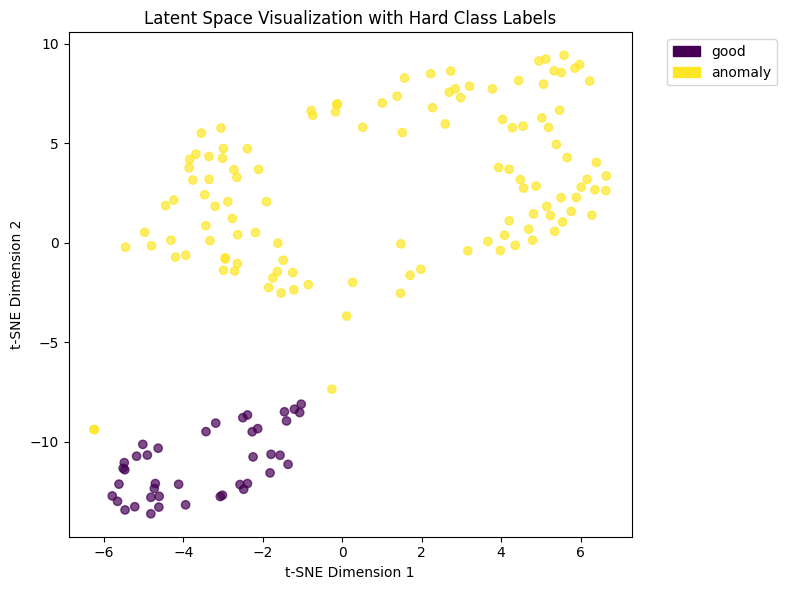

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model

def extract_latent_representations(autoencoder, test_generator, layer_name='bottleneck'):
    """
    Extract latent representations from the encoder part of an autoencoder.
    
    Parameters:
    autoencoder (Model): The full autoencoder model.
    test_generator (Sequence): The data generator for test images.
    layer_name (str): The name of the bottleneck layer to extract features from.

    Returns:
    np.ndarray: Flattened latent representations of the images.
    np.ndarray: Original image labels.
    """
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

    all_images, all_labels = zip(*(next(test_generator) for _ in range(len(test_generator))))

    # Concatenate all batches
    original_images = np.concatenate(all_images)
    labels = np.concatenate(all_labels)

    # Convert one-hot encoded labels to binary class indices
    labels_indices = np.where((labels == [1, 0, 0, 0, 0, 0]).all(axis=1), 0, 1)

    # Get latent representations and flatten spatial dimensions
    latent_representations = encoder.predict(original_images, verbose=0)
    latent_flat = latent_representations.reshape(latent_representations.shape[0], -1)

    return latent_flat, labels_indices

def apply_tsne(latent_representations, n_components=2):
    """
    Apply t-SNE to reduce dimensionality of latent representations.

    Parameters:
    latent_representations (np.ndarray): Flattened latent representations of images.
    n_components (int): Number of dimensions for t-SNE.
    perplexity (float): Perplexity parameter for t-SNE.
    n_iter (int): Number of iterations for optimization.

    Returns:
    np.ndarray: 2D representations of the latent space.
    """
    tsne = TSNE(n_components=n_components)
    latent_2d = tsne.fit_transform(latent_representations)
    return latent_2d

def plot_latent_space(latent_2d, labels_indices, class_indices):
    """
    Plot the latent space with class labels.

    Parameters:
    latent_2d (np.ndarray): 2D representations of the latent space.
    labels_indices (np.ndarray): Class indices for each image.
    class_indices (dict): Mapping of class names to class indices.
    """
    index_to_class = {v: k for k, v in class_indices.items()}
    num_classes = len(class_indices)

    # Define colormap and legend patches
    cmap = plt.cm.get_cmap('viridis', num_classes)
    patches = [mpatches.Patch(color=cmap(i), label=index_to_class[i]) for i in range(num_classes)]

    # Plot latent space with class labels
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels_indices, cmap=cmap, alpha=0.7)
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Latent Space Visualization with Hard Class Labels')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.tight_layout()
    plt.show()

class_indices = {'good': 0, 'anomaly': 1}

# Step 1: Extract latent representations
latent_representations, labels_indices = extract_latent_representations(autoencoder, test_generator)

# Step 2: Apply t-SNE
latent_2d = apply_tsne(latent_representations)

# Step 3: Plot latent space
plot_latent_space(latent_2d, labels_indices, class_indices)